In [89]:
file_path_cif_1 = 'real_inputs/yMRC1_15S.cif'
file_path_cif_2 = 'real_inputs/yMRC2_15S.cif'

output_file_path_1 = file_path_cif_1.split(".cif")[0] + "_with_cols.cif"
output_file_path_2 = file_path_cif_2.split(".cif")[0] + "_with_cols.cif"

# Fix columns for gemmi reading
def reformat_file(file_path, out_file):
    with open(file_path, 'r') as input_file, open(out_file, 'w') as output_file:
        ready_for_atoms = False
        for line in input_file:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                output_file.write(line.rsplit(maxsplit = 2)[0] + ' ' + line.split()[8].ljust(4) + ' ' + 
                                  line.split()[5].ljust(3) + ' ' + line.split()[16].ljust(2) + ' ' + 
                                  line.split()[3].ljust(4) + ' ' + line.split()[17].ljust(2) + '\n')
                ready_for_atoms = False
            elif not ready_for_atoms:
                if line.startswith('_atom_site.pdbx_formal_charge'):
                    ready_for_atoms = True
                    output_file.write("_atom_site.pdbx_formal_charge \n_atom_site.auth_seq_id \n_atom_site.auth_comp_id \n_atom_site.auth_asym_id \n_atom_site.auth_atom_id \n_atom_site.pdbx_PDB_model_num \n")
                else:
                    output_file.write(line)
                    
reformat_file(file_path_cif_1, output_file_path_1)
reformat_file(file_path_cif_2, output_file_path_2)

In [90]:
import gemmi
import pandas as pd
import inspect
import numpy as np

structure = gemmi.read_structure(output_file_path_1)
structure2 = gemmi.read_structure(output_file_path_2)

# Read in structures to dataframes
def read_in_structure(structure):
    atom_names = []
    residue_names = []
    chain_ids = []
    residue_numbers = []
    x_coords = []
    y_coords = []
    z_coords = []

    for chain in structure[0]:
        for residue in chain:
            for atom in residue:
                atom_names.append(atom.name)
                residue_names.append(residue.name)             
                chain_ids.append(chain.name)
                residue_numbers.append(residue.seqid.num)
                x_coords.append(atom.pos.x)
                y_coords.append(atom.pos.y)
                z_coords.append(atom.pos.z)

    data = {
        'AtomName': atom_names,
        'ResidueName': residue_names,
        'ChainID': chain_ids,
        'ResidueNumber': residue_numbers,
        'X': x_coords,
        'Y': y_coords,
        'Z': z_coords
    }

    df = pd.DataFrame(data)
    return df

df = read_in_structure(structure)
df2 = read_in_structure(structure2)

df['structure'] = 'yMRC1'
df2['structure'] = 'yMRC2'
df = pd.concat([df, df2], ignore_index=True)

In [91]:
df_all_atoms = df[df['structure'] == 'yMRC1']
df_all_atoms = df_all_atoms[['X', 'Y', 'Z']].to_numpy()
df = df[df['AtomName'].isin(['CA', 'P'])]
df_sub = df
df_sub['structure'].value_counts()

grouped = df_sub.groupby('structure')
result = pd.concat([group.sort_values(by=['ChainID', 'ResidueNumber']) for name, group in grouped], ignore_index=True)

subset_1 = result.loc[result['structure'] == 'yMRC1'][['ChainID', 'ResidueNumber']]
subset_2 = result.loc[result['structure'] == 'yMRC2'][['ChainID', 'ResidueNumber']]

subset_1.reset_index(inplace=True, drop=True)
subset_2.reset_index(inplace=True, drop=True)

# Compare two structures and show different rows if one structure is missing atoms
if not subset_1.equals(subset_2):
    merged_df = subset_1.merge(subset_2, how='outer', indicator=True)

    in_df1_only = merged_df[merged_df['_merge'] == 'left_only']
    in_df1_only = in_df1_only.drop(columns=['_merge'])
    in_df2_only = merged_df[merged_df['_merge'] == 'right_only']
    in_df2_only = in_df2_only.drop(columns=['_merge'])

    print("Rows unique to df1:")
    print(in_df1_only)

    print("\nRows unique to df2:")
    print(in_df2_only)

Rows unique to df1:
Empty DataFrame
Columns: [ChainID, ResidueNumber]
Index: []

Rows unique to df2:
     ChainID  ResidueNumber
1497      AL           1072


In [92]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

subset_1_df = result.loc[result['structure'] == 'yMRC1']
subset_2_df = result.loc[result['structure'] == 'yMRC2']

subset_2_df = subset_2_df[~(subset_2_df.ResidueNumber == 1072)] # Drop extra residue
subset_2_df.reset_index(inplace=True, drop=True)

subset_1_df.reset_index(inplace=True, drop=True)
subset_2_df.reset_index(inplace=True, drop=True)

# Convert to coordinate array
subset_1 = subset_1_df[['X', 'Y', 'Z']].to_numpy()
subset_2 = subset_2_df[['X', 'Y', 'Z']].to_numpy()

subset_1 = subset_1 - np.mean(df_all_atoms, axis=0)
subset_2 = subset_2 - np.mean(df_all_atoms, axis=0)

df_all_atoms = df_all_atoms - np.mean(df_all_atoms, axis=0)

In [93]:
import plotly.graph_objects as go
import imageio

###############
# 3D Plotting #
###############

# Rotate structure for viewing
rot_vec = np.array([1,1,0])
rot_vec = rot_vec / np.linalg.norm(rot_vec)
theta = -0.1 * np.pi
K = np.array([[0, -rot_vec[2], rot_vec[1]],
              [rot_vec[2], 0, -rot_vec[0]],
              [-rot_vec[1], rot_vec[0], 0]])
R = np.eye(3) + np.sin(theta) * K + (1 - np.cos(theta)) * np.dot(K, K)

subset_1 = subset_1.dot(R)
subset_2 = subset_2.dot(R)
df_all_atoms = df_all_atoms.dot(R)

# Create a cone plot
cone_trace = go.Cone(
    x=subset_1[:, 0],
    y=subset_1[:, 1],
    z=subset_1[:, 2],
    u=subset_2[:, 0] - subset_1[:, 0],
    v=subset_2[:, 1] - subset_1[:, 1],
    w=subset_2[:, 2] - subset_1[:, 2],
    sizemode="absolute",
    sizeref=20,
    showscale=True
)

# Create a point cloud of all atoms
gray_spheres_trace = go.Scatter3d(
    x=df_all_atoms[:, 0],
    y=df_all_atoms[:, 1],
    z=df_all_atoms[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color='gray',
        opacity=0.3
    )
)

fig = go.Figure(data=[cone_trace, gray_spheres_trace])

# Start frame
frame = 23
frames = 60
rotation_angle = 360 / frames
fig.update_layout(scene_camera=dict(eye=dict(x=1.2*np.cos(np.radians(frame*rotation_angle)),
                                                  y=1.2*np.sin(np.radians(frame*rotation_angle)),
                                                  z=0)))
# Check the orientation looks right
fig.show()

# Switch to final plotting view
fig.update_scenes(xaxis_visible=False, yaxis_visible=False ,zaxis_visible=False)
fig.update_layout(
    legend_title="Shift (Angstroms)",
    font=dict(
        size=48,
    )
)

frames_list = []

# Rotate the structure and record frames
for frame in range(frames):
    frame = (frame + 23) % 60
    print(frame)
    fig.update_layout(scene_camera=dict(eye=dict(x=1.2*np.cos(np.radians(frame*rotation_angle)),
                                                  y=1.2*np.sin(np.radians(frame*rotation_angle)),
                                                  z=0)))
    frame_image = go.Figure(fig).to_image(format="png", width=2400, height=1600)
    frames_list.append(imageio.imread(frame_image))

imageio.mimsave('outputs/yMRC1_to_yMRC2_15S_3D_rotation.gif', frames_list, duration=0.2)

23


/var/folders/sd/kt91y68x51v580jtrx05xmjw0000gn/T/ipykernel_7536/512990006.py:77: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


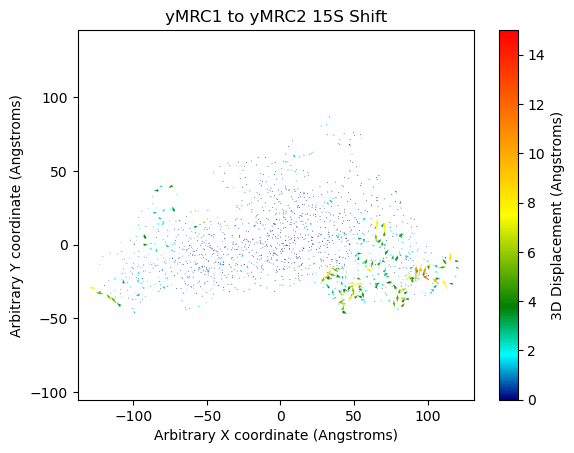

In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

###############
# 2D Plotting #
###############

# Rotate structure for 2D projection
rot_vec = np.array([1,1,0])
rot_vec = rot_vec / np.linalg.norm(rot_vec)
theta = 0.1 * np.pi
K = np.array([[0, -rot_vec[2], rot_vec[1]],
              [rot_vec[2], 0, -rot_vec[0]],
              [-rot_vec[1], rot_vec[0], 0]])
R = np.eye(3) + np.sin(theta) * K + (1 - np.cos(theta)) * np.dot(K, K)

subset_1 = subset_1.dot(R)
subset_2 = subset_2.dot(R)
df_all_atoms = df_all_atoms.dot(R)

def gram_schmidt(v):
    u1 = v / np.linalg.norm(v)
    v2 = np.array([0,0,1])
    v2 = v2 / np.linalg.norm(v2)
    u2 = v2 - np.dot(v2, u1) * u1
    u2 /= np.linalg.norm(u2)
    u3 = np.cross(u1, u2)    
    return u1, u2, u3

def project_onto_plane(points, normal_vector, bias):
    normalized_normal = normal_vector / np.linalg.norm(normal_vector)
    u1, u2, u3 = gram_schmidt(normalized_normal)
    return np.column_stack((points.dot(u3), points.dot(u2)))

# Normal vector and bias of the plane
normal_vector = np.array([-1,1,-1])
normal_vector = normal_vector / np.linalg.norm(normal_vector)
bias = np.array([0,0,0])

# Project structure onto plane
projected_subset_1 = project_onto_plane(subset_1, normal_vector, bias)
projected_subset_2 = project_onto_plane(subset_2, normal_vector, bias)

# 3D distances of backbone atoms
magnitudes = np.sqrt(np.sum(np.square(subset_1 - subset_2), axis=1))

x = -projected_subset_1[:, 0] # Flip x to make sure it matches the 3D view
y = projected_subset_1[:, 1]
x2 = -projected_subset_2[:, 0]
y2 = projected_subset_2[:, 1]

cmap = mcolor.LinearSegmentedColormap.from_list('colors',
                                                [(0, 'navy'),
                                              (0.12, 'cyan'),
                                              (0.25, 'green'),
                                              (0.5, 'yellow'),
                                              (1, 'red')], N=256)

# Create vector plot
plt.quiver(x, y, x2-x, y2-y, magnitudes, angles='xy', scale_units='xy', scale=1, cmap=cmap)
plt.clim(0,15)

plt.axis('equal')
plt.xlabel('Arbitrary X coordinate (Angstroms)')
plt.ylabel('Arbitrary Y coordinate (Angstroms)')
plt.title('yMRC1 to yMRC2 15S Shift')
plt.colorbar(label='3D Displacement (Angstroms)')

plt.savefig('outputs/yMRC1_to_yMRC2_15S_X_Y_shift.pdf', format='pdf', dpi=3000, bbox_inches='tight')
plt.show()